In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import statsmodels.api as sm2
import statistics as stat
import time
from numpy.random import normal
import seaborn as sns
import pylab
from scipy import optimize as opt
from scipy import stats as st
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from matplotlib.pyplot import figure
from sklearn.decomposition import PCA
from bisect import bisect_left
import timeit
import scipy 
import math
import pypfopt
from datetime import datetime
from risk_lib import VaR,ES

In [2]:
def bsm(is_call: bool, underlying_price, strike, ttm, rf, hc, ivol):
    b = rf - hc
    d1 = (np.log(underlying_price/strike) + (b + (ivol**2)/2)*ttm) / (ivol*np.sqrt(ttm))
    d2 = d1 - ivol*np.sqrt(ttm)
    if(is_call):
        return underlying_price*np.e**((b-rf)*ttm)*scipy.stats.norm(0, 1).cdf(d1) - strike*np.e**(-rf*ttm)*scipy.stats.norm(0, 1).cdf(d2)
    else:
        return strike*np.e**(-rf*ttm)*scipy.stats.norm(0, 1).cdf(-d2)-underlying_price*np.e**((b-rf)*ttm)*scipy.stats.norm(0, 1).cdf(-d1)

# Problem 1

Time to maturity is :  0.057534246575342465  years


/Users/fredpeng/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/fredpeng/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


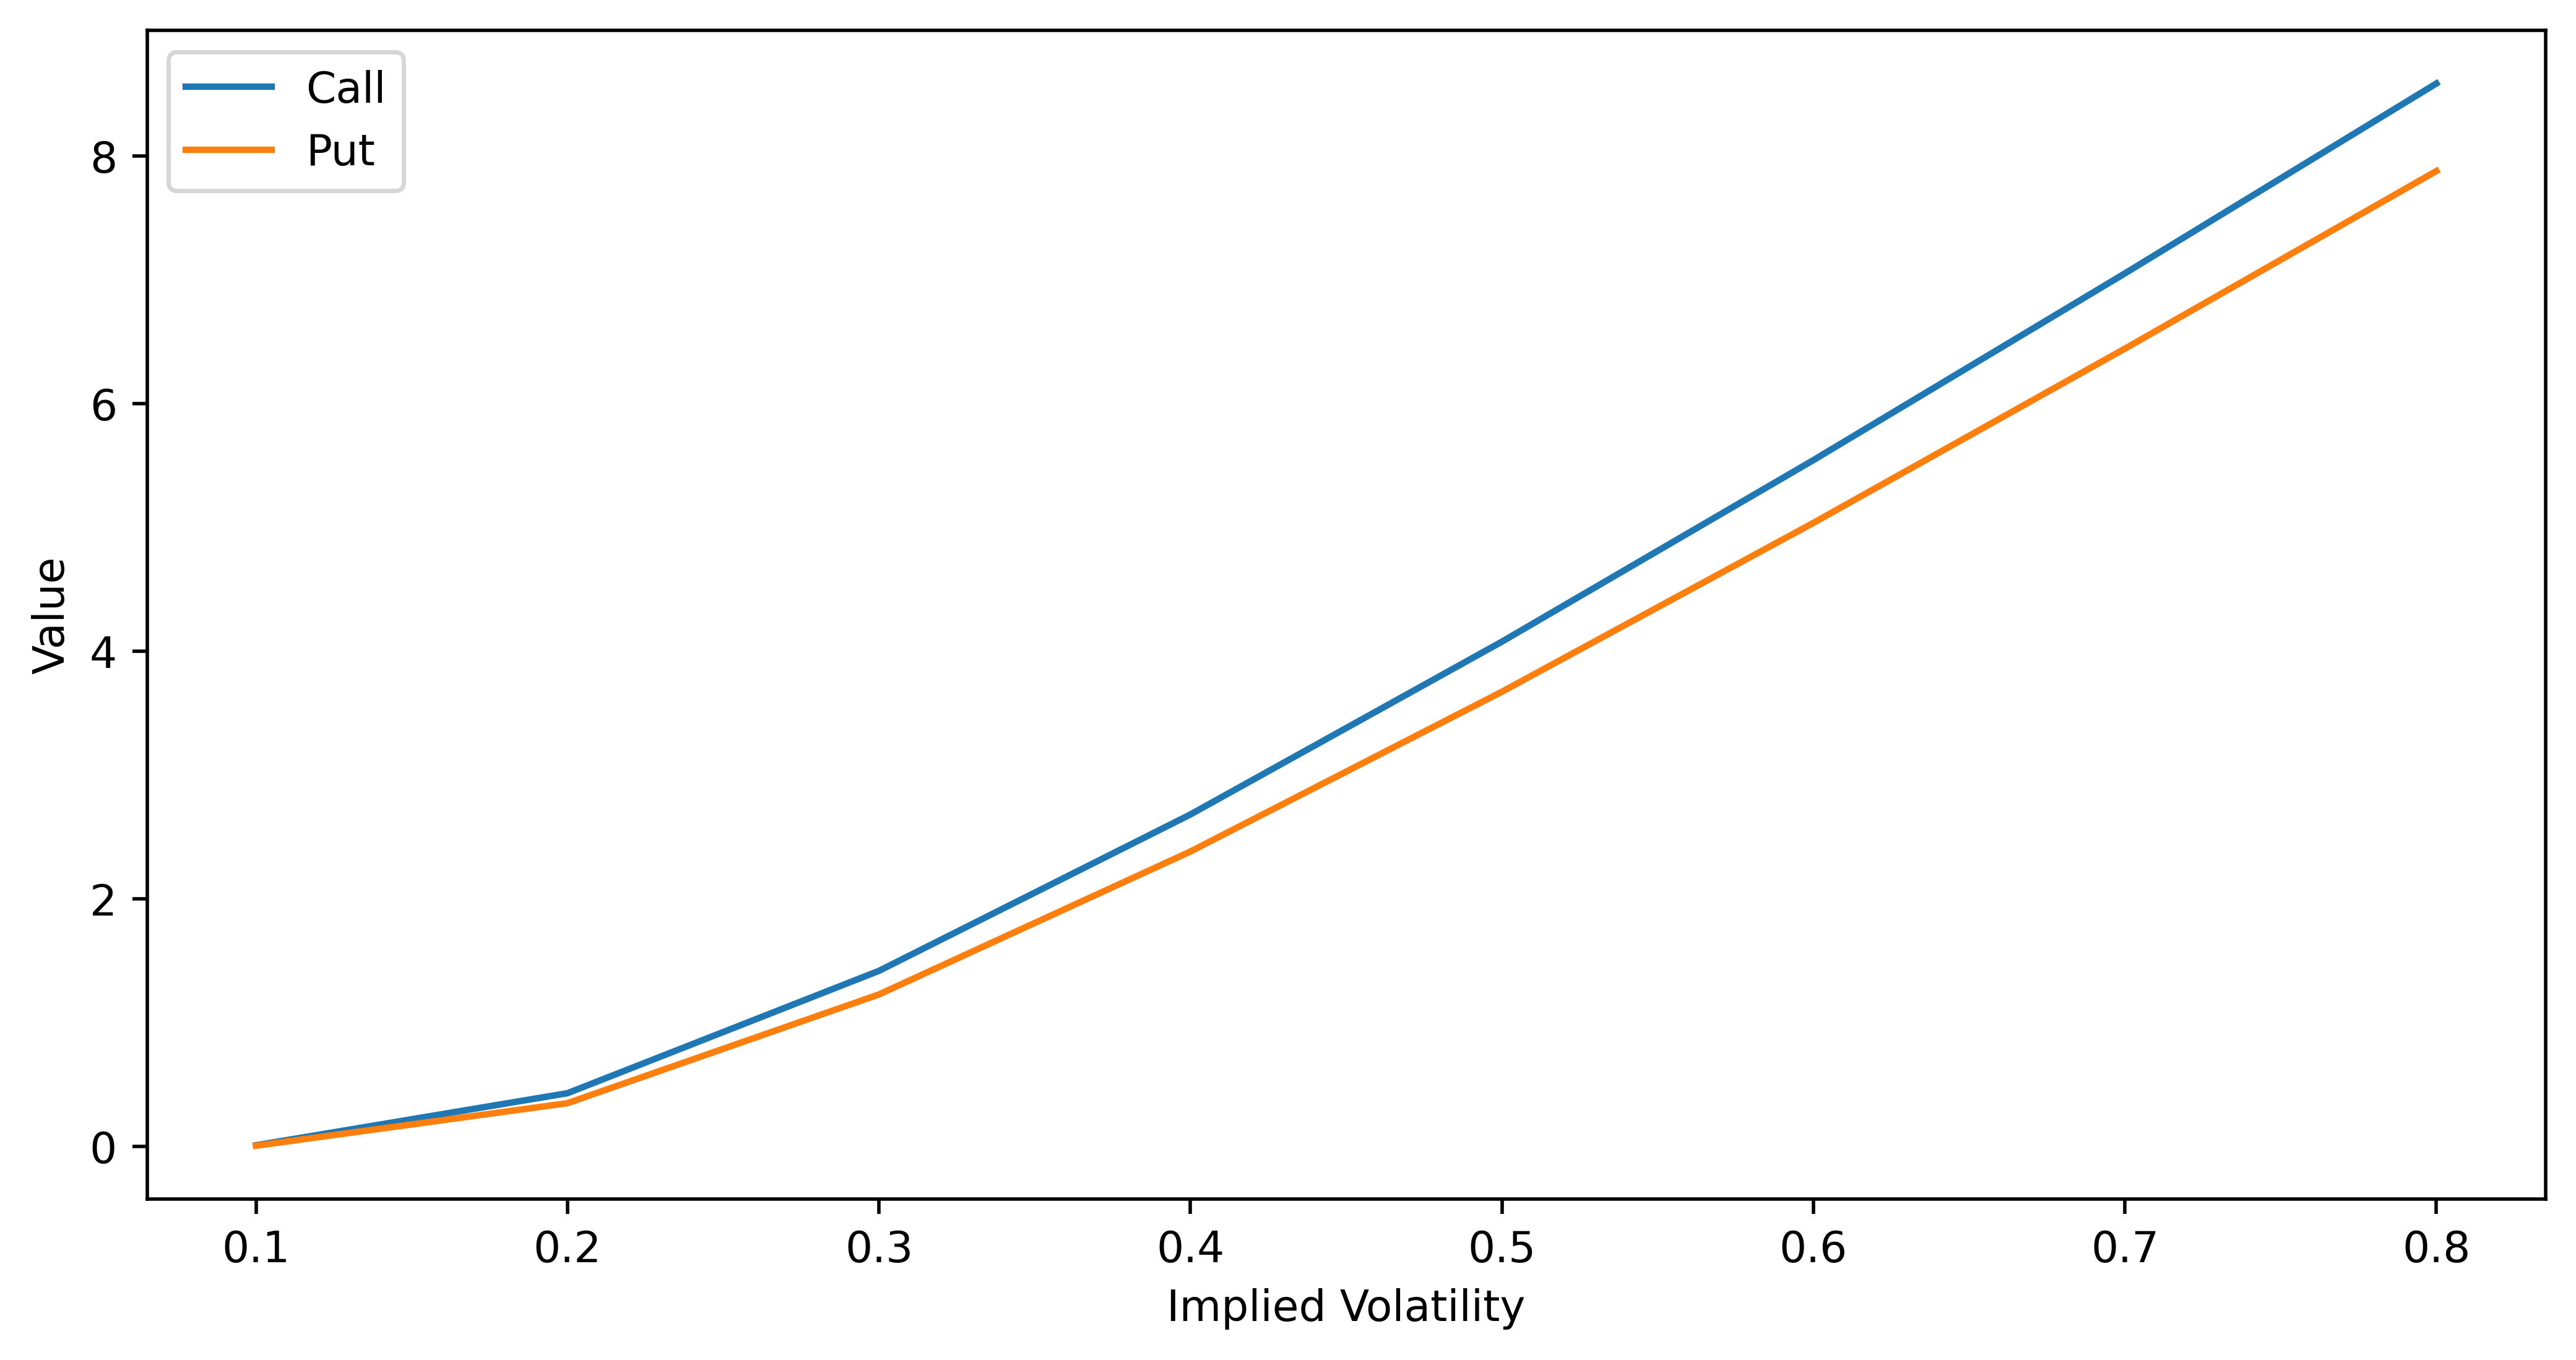

In [3]:
p = 165
t = (datetime(2022, 3, 18) - datetime(2022, 2, 25)).days / 365
print("Time to maturity is : ",t," years")
rf = 0.0025 
q = 0.0053
stdev = np.linspace(0.1, 0.8, 8)
call_values = np.array([bsm(True, p, p+10, t, rf, q, s) for s in stdev]) 
put_values = np.array([bsm(False, p, p-10, t, rf, q, s) for s in stdev])
fig, ax = plt.subplots(figsize=(10,5),dpi=500)
sns.lineplot(stdev, call_values, ax=ax, label='Call')
sns.lineplot(stdev, put_values, ax=ax, label='Put')
ax.set_xlabel("Implied Volatility")
ax.set_ylabel("Value")
ax.legend()

# Problem 2

In [4]:
def implied_vol(is_call: bool, underlying_price, strike, ttm, rf, hc, opt_value):
    def formula(vol):
        return bsm(is_call, underlying_price, strike, ttm, rf, hc, vol) - opt_value
    return scipy.optimize.fsolve(formula, x0=(0.5))[0]

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/dompazz/FinTech590-RiskManagement/main/Week06/Project/AAPL_Options.csv")
strike = df['Strike']
Type = df['Type']=='Call'
p = df['Last Price']
ivol = []
for i in range(len(strike)):
    ivol.append(implied_vol(Type[i],164.85,strike[i],t,0.0025,0.0053,p[i]))
df['Implied vol'] = np.array(ivol)
df


,Stock,Expiration,Type,Strike,Last Price,Implied vol
0,AAPL,3/18/2022,Call,135.0,30.175,0.499898
1,AAPL,3/18/2022,Call,140.0,25.300,0.452886
2,AAPL,3/18/2022,Call,145.0,20.525,0.412720
3,AAPL,3/18/2022,Call,150.0,15.850,0.369706
4,AAPL,3/18/2022,Call,155.0,11.525,0.340394
5,AAPL,3/18/2022,Call,160.0,7.525,0.304316
6,AAPL,3/18/2022,Call,165.0,4.225,0.273378
7,AAPL,3/18/2022,Call,170.0,1.935,0.249889
8,AAPL,3/18/2022,Call,175.0,0.715,0.235938
9,AAPL,3/18/2022,Call,180.0,0.260,0.237799


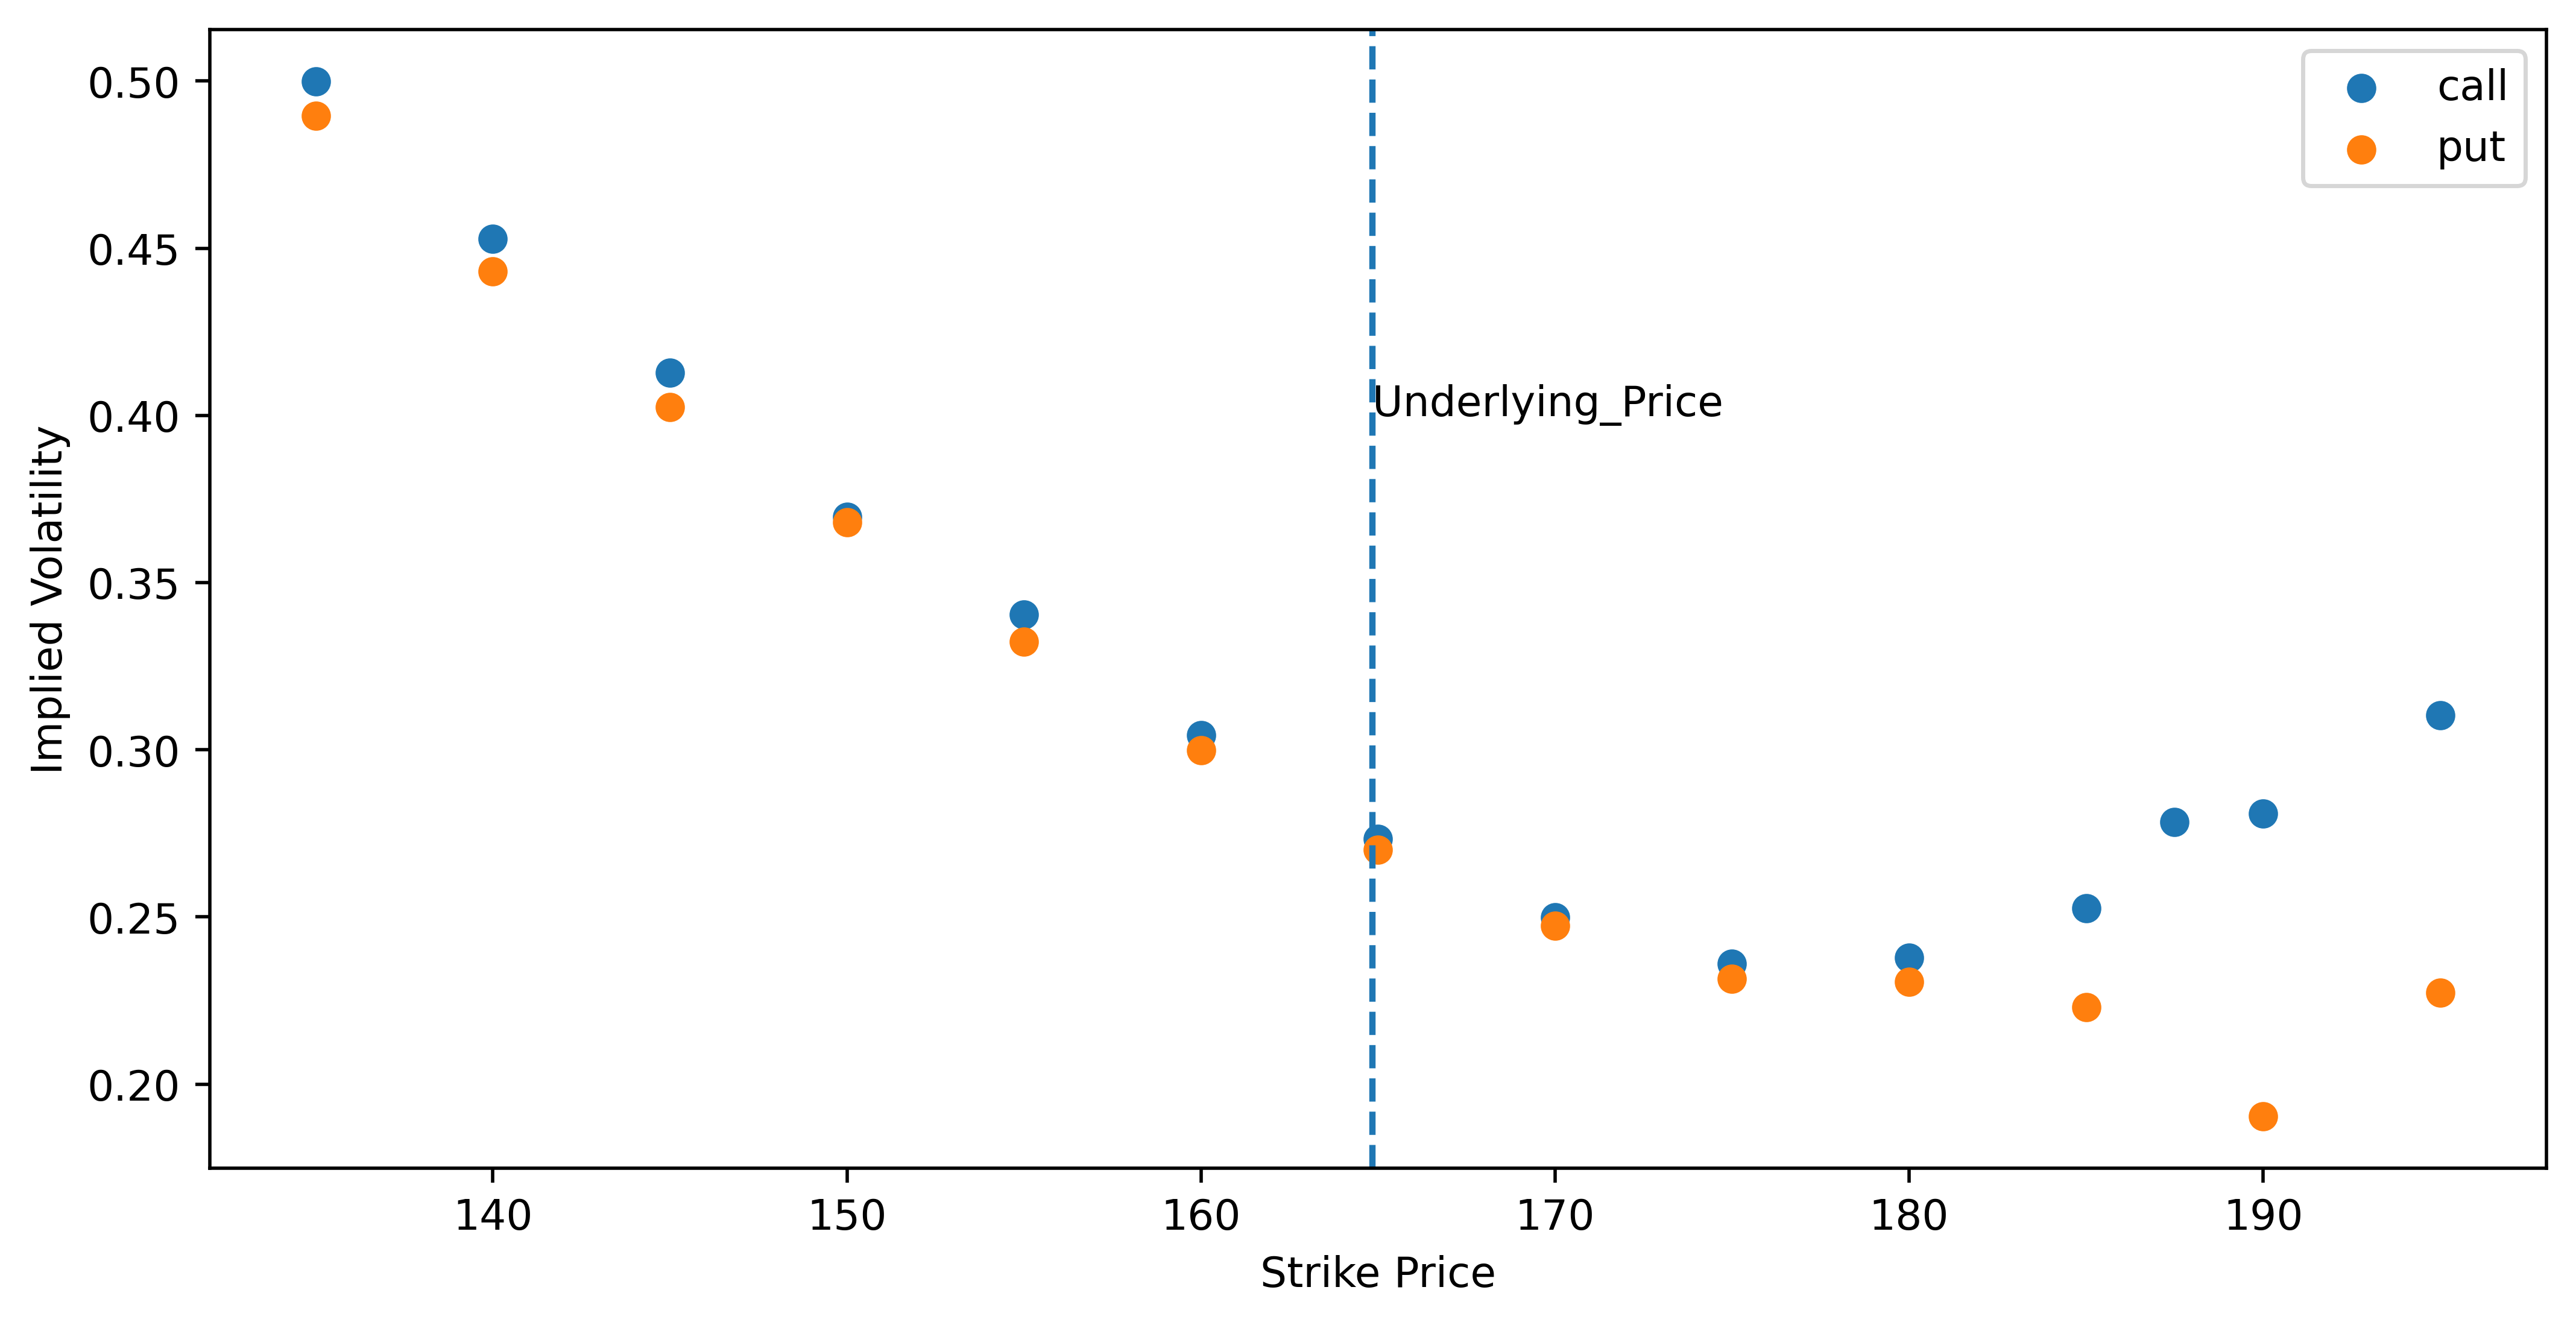

In [6]:
fig, axes = plt.subplots(figsize=(10,5),dpi=500)
call = df[df['Type']=='Call']
put = df[df['Type']=='Put']
axes.scatter(x = call['Strike'], y = call['Implied vol'], label = 'call')
axes.scatter(x = put['Strike'], y = put['Implied vol'],label = 'put')
axes.set_xlabel("Strike Price")
axes.set_ylabel("Implied Volatility")
axes.axvline(x = 164.85, linestyle='dashed')
axes.text(x=164.85, y=0.4, s='Underlying_Price')
plt.legend()

# Problem 3

In [7]:
def calc_value(port, underlying_values, simulated_date):
    result = pd.DataFrame(port['Portfolio'])
    
    for price in underlying_values:
        values = []
        for i in range(len(port)):
            if port['Type'][i] == 'Option':
                ttm = (pd.to_datetime(port['ExpirationDate'][i])-simulated_date).days/365
                if port['OptionType'][i] == 'Call':
                    value=bsm(True, price, port["Strike"][i], ttm, rf, q, port["Implied volatility"][i])*port["Holding"][i]
                elif port['OptionType'][i] == 'Put':
                    value=bsm(False, price, port["Strike"][i], ttm, rf, q, port["Implied volatility"][i])*port["Holding"][i]
                values.append(value)
            else:
                values.append(price)
        result[str(price)] = np.array(values)
        
    result = result.groupby('Portfolio').sum()
    return result

In [8]:
port=pd.read_csv("https://raw.githubusercontent.com/dompazz/FinTech590-RiskManagement/main/Week06/Project/problem3.csv")
port

,Portfolio,Type,Underlying,Holding,OptionType,ExpirationDate,Strike,CurrentPrice
0,Straddle,Option,AAPL,1,Call,3/18/2022,165.0,4.50
1,Straddle,Option,AAPL,1,Put,3/18/2022,165.0,4.40
2,SynLong,Option,AAPL,1,Call,3/18/2022,165.0,4.50
3,SynLong,Option,AAPL,-1,Put,3/18/2022,165.0,4.40
4,CallSpread,Option,AAPL,1,Call,3/18/2022,165.0,4.50
5,CallSpread,Option,AAPL,-1,Call,3/18/2022,175.0,0.72
6,PutSpread,Option,AAPL,1,Put,3/18/2022,165.0,4.40
7,PutSpread,Option,AAPL,-1,Put,3/18/2022,155.0,1.60
8,Stock,Stock,AAPL,1,NaN,NaN,NaN,164.85
9,Call,Option,AAPL,1,Call,3/18/2022,165.0,4.50


In [9]:
ttm = (datetime(2022,3,18) - datetime(2022,2,25)).days/365
strike = port['Strike']
is_call = np.array([ 1.,  0.,  1.,  0.,  1.,  1.,  0.,  0., np.nan,  1.,  0., np.nan,  1.,np.nan,  0.])
opt_value = port['CurrentPrice']
imp_vol = []

for i in range(len(strike)):
    if port['Type'][i]=='Option':
        imp_vol.append(implied_vol(is_call[i],164.85,strike[i],ttm,0.0025,0.0053,opt_value[i]))
    else:
        imp_vol.append(np.nan)       
port['Implied volatility'] = np.array(imp_vol)
values = calc_value(port, list(range(100,500)),datetime(2022,2,25)).T

fig, axes = plt.subplots(3, 3, figsize=(20, 20),dpi=500)
i=0
for v in values.columns:
    values[v].plot(ax = axes[i//3][i%3])
    axes[i//3][i%3].set_title(v)
    axes[i//3][i%3].set_xlabel("Underlying Value")
    axes[i//3][i%3].set_ylabel("Portfolio Value")
    i=i+1


/var/folders/r8/46qbgcxj5jl_n265fhkxg2qw0000gn/T/ipykernel_44581/1840382711.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  result[str(price)] = np.array(values)


In [10]:
from scipy import stats as st
ret= pd.read_csv("https://raw.githubusercontent.com/dompazz/FinTech590-RiskManagement/main/Week06/Project/DailyReturn.csv",index_col=0)['AAPL']
σ = ret.std()
ret_sim = scipy.stats.norm(0, σ).rvs((10, 1000))
simed = pd.DataFrame(164.85 * (1 + ret_sim).prod(axis=0))
portval_bar = calc_value(port, simed.values,datetime(2022,3,7))
port['Value'] = port["CurrentPrice"]*port['Holding']
portval = port.groupby('Portfolio').sum()['Value']
port_list = (portval_bar.div(portval,axis=0)-1).T
Mean_bar,VaR_bar,ES_bar = [],[],[]
for strategy in port_list.columns:
    Mean_bar.append(port_list[strategy].mean())
    VaR_bar.append(VaR.VaR_His(port_list[strategy],0.05))
    ES_bar.append(ES.ES(port_list[strategy],0.05))
pd.DataFrame({'Mean':Mean_bar,'VaR':VaR_bar,'ES':ES_bar},index =port_list.columns )



/var/folders/r8/46qbgcxj5jl_n265fhkxg2qw0000gn/T/ipykernel_44581/1840382711.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  result[str(price)] = np.array(values)


,Mean,VaR,ES
Portfolio,,,
Call,-0.030997,0.970262,0.985859
CallSpread,-0.093097,0.964677,0.983190
CoveredCall,-0.002014,0.058050,0.078658
ProtectedPut,-0.000089,0.024480,0.024790
Put,0.101693,0.957305,0.978478
PutSpread,0.173506,0.941960,0.970655
Stock,-0.002805,0.082951,0.103422
Straddle,0.034603,0.274430,0.275518
SynLong,-5.869339,138.975409,172.897045
